# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [24]:
import unidecode
import string
import random
import re
import numpy as np
import os
import json

n_characters = 2**16 # basic multilingual plane
kPadCharIndex = n_characters
kPadChar = chr(kPadCharIndex) # padding for batch
kSOTChar = '\u0002'
kEOTChar = '\u0003'
n_characters += 1

max_chunk_len = 40
stride = 20

json_fn = '../data/sentences_c%d_s%d.json' % (max_chunk_len, stride)
if os.path.exists(json_fn):
    with open(json_fn, 'r') as f:
        dataset = json.load(f)
        sentences, ords = dataset['sentences'], dataset['ords']
else:
    file = open('../data/sentences.csv').readlines()
    sentences = []
    for l in file:
        assert(l[-1] == '\n')
        s = l.split('\t')[-1][:-1]
        o = [ord(c) for c in s]
        if len(s) <= 0 or np.amax(o) >= n_characters -1:
            continue
        
        s = kSOTChar + s + kEOTChar
        if len(s) < max_chunk_len:
            sentences.append(s)
        else:
            for i in range(0, len(s) - max_chunk_len + 1, stride):
                sub_str = s[i:i+max_chunk_len]
                sentences.append(sub_str)
    sentences = sorted(sentences, key=len)
    ords = [[ord(c) for c in s] for s in sentences]
    with open(json_fn, 'w') as outfile:
        json.dump({'sentences': sentences, 'ords': ords}, outfile)

file_len = len(ords)
print('file_len =', file_len)

file_len = 7664627


In [25]:
print(len(sentences[0]), len(sentences[-1]))
print(sentences[:10])
print(sentences[-10:])

3 40
['\x02네\x03', '\x02.\x03', '\x02錯。\x03', '\x02行。\x03', '\x02啥？\x03', '\x02滾。\x03', '\x02係。\x03', '\x02嘘！\x03', '\x02え？\x03', '\x02mo\x03']
['\x02Vocês poderiam me ajudar a traduzir iss', '\x02Posso usar o teu computador para olhar ', '\x02The police recovered the stolen jewels.', '\x02Do you think Tom will be in Boston all ', "\x02Let's just say that I wasn't surprised.", "\x02Do you still think that's all Tom needs", "\x02It won't be as easy to do as you think.", '\x02Do you know what Tom is going to do nex', '\x02Do you mind if I lay down on the sofa?\x03', '\x02Ik verwachte Peter, maar het was zijn b']


To make inputs out of this big string of data, we will be splitting it into chunks.

In [26]:
batch_size = 10

# output size (seq_len, batch_size)
def random_chunk():
    index = random.randint(0, file_len-batch_size)
    batch_s = ords[index: index + batch_size]
    lens = [len(s) for s in batch_s]
    max_len = np.amax(lens)
    if (lens < max_len).any():
        batch_s = [s + [kPadCharIndex,] * (max_len - len(s)) for s in batch_s]
    return np.array(batch_s, dtype = int)

print(random_chunk())

[[   2   69  107   32  119  105  108   32  110  105  101   32   97  108
   108  101  101  110   32   98  108  121   32  110  105  101   46    3]
 [   2   78  111  110   32  118  111  114  114  101  105   32  114  105
   109   97  110  101  114  101   32  115  101  110  122   97   33    3]
 [   2   83   99  117  115   97  116  101   44   32  110  111  110   32
   104  111   32  114  101  115  105  115  116  105  116  111   33    3]
 [   2   69  107   32  119  105  108   32  106  117  108  108  101   32
   110  105  101   32  115  105  101  110   32  110  105  101   46    3]
 [   2   77  225  114   32  115  111  107   32  104  101  108  121  101
   110   32  109  101  103  102  111  114  100  117  108  116   46    3]
 [   2 1332 1400 1410 1412   32 1389 1400 1405 1400 1410 1374 1396   32
  1381 1412   32 1414 1408 1377 1398 1405 1381 1408 1381 1398   58    3]
 [   2  199   97   98  117  107   32  111  108   33   32   89  101  109
   101  107   32  115  111  287  117  121   97   99   97  

# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [27]:
import torch
import torch.nn as nn
from torch.autograd import Variable

def cuda_if_available(v):
    return v.cuda() if torch.cuda.is_available() else v

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first = True)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    # output:(batch, seq_len, out_size),
    # hidden: (num_layers * num_directions, batch, hidden_size)
    def forward(self, input, hidden):
        input = self.encoder(input) # (B, seq_len, embedding_dim)
        output, hidden = self.gru(input, hidden) # output:(batch, seq_len, hidden_size * num_directions),
        output = self.decoder(output)
        return output, hidden

    def init_hidden(self, batch_size):
        v = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
        return cuda_if_available(v)

In [28]:
from pdb import set_trace as st

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [29]:
def cuda_if_available(v):
    return v.cuda() if torch.cuda.is_available() else v


# Turn string into list of longs
def char_tensor(ords_batch):
    tensor = torch.from_numpy(ords_batch).long()
    v = Variable(tensor)
    return cuda_if_available(v)

# size: (B, seq_len)
def random_training_set():
    while True:
        chunk = random_chunk()
        if chunk.shape[1] > 1:
            break
    inp = char_tensor(chunk[:,:-1])
    target = char_tensor(chunk[:,1:])
    mask_np = (chunk[:,1:] != kPadCharIndex).astype(np.float32)
    mask = Variable(torch.from_numpy(mask_np), requires_grad = False)
    
    return inp, target, cuda_if_available(mask)

chunk = random_chunk()
print(chunk, char_tensor(chunk))
print(random_training_set())

[[   2   78  111  116   32   97  110  111  116  104  101  114   32  119
   111  114  100   33    3]
 [   2 1069 1090 1072   32 1088 1099 1073 1072   32 1074 1082 1091 1089
  1085 1072 1103   46    3]
 [   2 1492 1500 1493 1493 1488 1497   32 1513 1492 1497 1497 1514 1497
    32 1502 1514   46    3]
 [   2 2335 2377 2350   32 2358 2367 2357 2381 2351 2366   32 2342 2375
  2340 2379 2351   46    3]
 [   2 1040 1074 1090 1086 1073 1091 1089   32 1087 1086 1076 1093 1086
  1076 1080 1090   46    3]
 [   2   86  101  114  114  224   32   97  108  108   97   32  102  101
   115  116   97   46    3]
 [   2 1069 1081   33   32 1054 1090 1087 1091 1089 1090 1080   32 1084
  1077 1085 1103   33    3]
 [   2 1065 1077   32 1084 1080 1085 1072   32 1087 1086   45 1082 1098
  1089 1085 1086   46    3]
 [   2 1065 1077   32 1073 1098 1076 1072   32 1085 1072 1082 1072 1079
  1072 1085 1072   46    3]
 [   2  200   32  105  114  114  101   99  117  112  101  114   97   98
   105  108  101   46    3]]

Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [30]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden(1)
    prime_str = kSOTChar + prime_str
    prime_input = char_tensor(np.array([[ord(c) for c in prime_str]]))
    predicted = prime_str

    # Use priming string to "build up" hidden state
    _, hidden = decoder(prime_input[:,:-1], hidden)
    inp = prime_input[:,-1].view(1,1)
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = chr(top_i)
        predicted += predicted_char
        
        inp_np = np.array([[ord(predicted_char)]])
        inp = char_tensor(inp_np)

    return predicted

# evaluate('Wh', 10)

# Training

A helper to print the amount of time passed:

In [31]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [ ]:
# target, input: (batch, seq_len),
def train(inp, target, mask):
    hidden = decoder.init_hidden(batch_size)
    decoder.zero_grad()
    loss = 0
    
    seq_len = inp.size()[-1]
    # output:(batch, seq_len, out_size),
    # hidden: (num_layers * num_directions, batch, hidden_size)
    output, hidden = decoder(inp, hidden)
    loss_vec = criterion(output.view(-1, output.size()[-1]), target.view(-1)) # (batch*sesq_len)
    loss = (torch.mul(mask.view(-1), loss_vec)).mean()

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] #/ chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [ ]:
import json

n_epochs = 2*file_len//batch_size
print_every = 100
plot_every = 100
save_every = 2000
hidden_size = 512
n_layers = 1
batch_size=64
lr = 0.005

decoder = cuda_if_available(RNN(n_characters, hidden_size, n_characters, n_layers))
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(reduce=False)

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate("I'm going to", 10), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0
        
    if epoch % save_every == 0:
        torch.save(decoder.cpu().state_dict(), 'mytraining_new.pt')
        decoder = cuda_if_available(decoder)
        with open('losses_new.npy', 'w') as outfile:
            json.dump(all_losses, outfile)

 8s (100 0%) 2.9124]
I'm going ton what th  

 17s (200 0%) 5.6798]
I'm going to de são?  

 26s (300 0%) 2.5667]
I'm going tom onisiend 

 35s (400 0%) 2.3862]
I'm going to soure lil 

 43s (500 0%) 2.4763]
I'm going to deg tasen 

 52s (600 0%) 3.6732]
I'm going tolde, hay m 

 1s (700 0%) 2.7497]
I'm going to firida le 

 10s (800 0%) 2.9543]
I'm going to tos Tom m 

 19s (900 0%) 2.3294]
I'm going to tat-you m 

 28s (1000 0%) 3.3042]
I'm going toht bor he  

 36s (1100 0%) 2.4485]
I'm going to, ve lete  

 45s (1200 0%) 2.4776]
I'm going to Tom trie. 

 54s (1300 0%) 2.5635]
I'm going to era kaly. 

 3s (1400 0%) 2.6151]
I'm going to de de Ges 

 12s (1500 0%) 2.4133]
I'm going to onu but n 

 20s (1600 0%) 2.3665]
I'm going to thabow th 

 29s (1700 0%) 2.6089]
I'm going to felletrer 

 39s (1800 0%) 2.0596]
I'm going to. Tom in  

 48s (1900 0%) 2.2536]
I'm going to de de de  

 57s (2000 0%) 2.2996]
I'm going to doment to 

 10s (2100 0%) 2.7699]
I'm goin

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

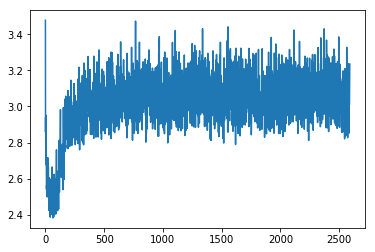

In [34]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [13]:
print(evaluate('Th', 200, temperature=0.8))

Th heok couns him.

KING EDWARD IV:
And fear allow is it he do soul, if who the min all his boldle eeve
Wousen me mady; good queie: the call extive your his?

QUEEN CAPLaLA:
And son hell plesend other r
